In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import sys
import preprocess
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

./train_32x32.mat found
./test_32x32.mat found
(32, 32, 3, 73257)
(32, 32, 3, 73257)


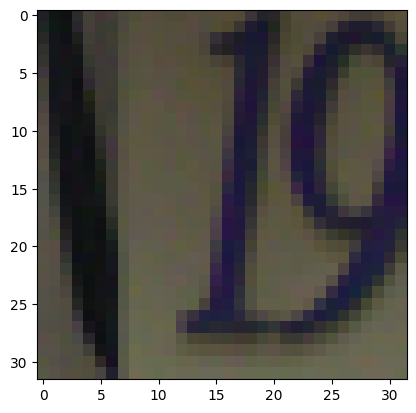

In [2]:
    # Adjust file paths as needed for your local file system
    file_path = './train_32x32.mat'

    # Check if file is in your specified local directory
    if not os.path.exists(file_path):
        print(file_path," not found, exiting")
        sys.exit()
    else:
        print(file_path, "found")

    # Load the training data
    train_mat = scipy.io.loadmat(file_path)

    # categorize the data
    X_tr = train_mat['X']
    y_tr = train_mat['y']
    y_tr = y_tr.astype(int)

    file_path = "./test_32x32.mat"
    if not os.path.exists(file_path):
        print(file_path," not found, exiting")
        sys.exit()
    else:
        print(file_path, "found")

    # Load the test data
    test_mat = scipy.io.loadmat(file_path)

    X_te = test_mat['X']
    y_te = test_mat['y']
    y_te = y_te.astype(int)
    
    # split = 20000
    # X_tr = X_tr[:, :, :,:split]
    # y_tr = y_tr[:split]
    
    for i in range(y_tr.shape[0]):
        if y_tr[i] == 10:
            y_tr[i] = 0
    for i in range(y_te.shape[0]):
        if y_te[i] == 10:
            y_te[i] = 0
    print(X_tr.shape)
    # X_tr, X_te = preprocess.greyscale(X_tr, X_te)
    plt.imshow(X_tr[:,:,:,0])
    print(X_tr.shape)
    

In [3]:
    X_tr_reshaped = X_tr.reshape(X_tr.shape[3], -1)
    X_te_reshaped = X_te.reshape(X_te.shape[3], -1)
    
    scaler = MinMaxScaler()

    # Fitting on training, transform on both training and testing
    X_tr_scaled = scaler.fit_transform(X_tr_reshaped)
    X_te_scaled = scaler.transform(X_te_reshaped)

    X_tr = X_tr_scaled.reshape(X_tr.shape)
    X_te = X_te_scaled.reshape(X_te.shape)
    print(X_tr.shape)
    print(X_te.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [4]:
class ConvNet(nn.Module):
    def __init__(self, feature_map=20, kernel=5):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, feature_map, kernel)

        # Calculate the size of the feature map after the final pooling layer
        def conv2d_size_out(size, kernel_size=kernel, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1

        def pool_size_out(size, kernel_size=2, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv1_size = conv2d_size_out(32)
        pool1_size = pool_size_out(conv1_size)
        conv2_size = conv2d_size_out(pool1_size)
        pool2_size = pool_size_out(conv2_size)

        linear_input_size = pool2_size * pool2_size * feature_map

        # Fully connected layers
        self.fc1 = nn.Linear(linear_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
def test(X_te, y_te, model, batch_size, featureMap):
  # Testing the model
  X_te_transposed = X_te.transpose((3, 2, 0, 1))

  X_te_tensor = torch.from_numpy(X_te_transposed).float().to(device)
  y_te_tensor = torch.from_numpy(y_te).long().to(device)

  # Converting our tensors into a Tensor Dataset
  test_dataset = torch.utils.data.TensorDataset(X_te_tensor, y_te_tensor)

  # Creating a loader
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  print("testing the model...")
  correct_count, all_count = 0, 0
  for images,labels in test_loader:
    for i in range(len(labels)):
      img = images[i].view(1, 3, 32, 32)
      with torch.no_grad():
          logps = model(img)

      
      ps = torch.exp(logps)
      probab = list(ps.cpu()[0])
      pred_label = probab.index(max(probab))
      true_label = labels.cpu()[i]
      if(true_label == pred_label):
        correct_count += 1
      all_count += 1

  print("Number Of Images Tested =", all_count)
  print("\nModel Accuracy =", (correct_count/all_count))
  return (correct_count/all_count)

In [13]:
def epochTest(num_epochs):
    batch_size = 5
    learning_rate = 0.001

    device = torch.device("cuda")
    criterion = nn.CrossEntropyLoss()
    # First, converting our data into tensors
    X_tr_transposed = X_tr.transpose((3, 2, 0, 1))

    X_tr_tensor = torch.from_numpy(X_tr_transposed).float().to(device)
    y_tr_tensor = torch.from_numpy(y_tr).long().to(device)

    # Converting our tensors into a Tensor Dataset
    train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, y_tr_tensor)

    # Creating a loader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training the model
    n_total_steps = len(train_loader)
    epochs = [5,10,15,20,25,30,35,40,45,50]
    test_error = []
    train_error = []
    for e in epochs:
        model = ConvNet().to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        print(f"Training with {e} Epochs")
        for epoch in range(e):
            print(f"Epoch {epoch + 1}/{e}...")
            for i, batch in enumerate(train_loader):
                inputs, labels = batch
                labels = labels.squeeze()
                # Zeroing gradient
                optimizer.zero_grad()

                # Forward pass
                # (batch_size, 3, 32, 32)
                # (32, 32, 3, batch_size)
                outputs = model(inputs)

                # Applying loss
                loss = criterion(outputs, labels)

                # Backpropogation
                loss.backward()

                # Update our weights
                optimizer.step()

                # print(f"Epoch [{epoch + 1}/{e}], Batch [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
        test_error.append(1-test(X_te, y_te, model, batch_size, 20))
        train_error.append(1-test(X_tr, y_tr, model, batch_size, 20))
    plt.plot(epochs, train_error, label="Train Error")
    plt.plot(epochs, test_error, label="Test Error")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.title("Error vs. Epochs")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

In [10]:
batch_size = [5,10,15,20,25]
num_epochs = 25
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
# First, converting our data into tensors
X_tr_transposed = X_tr.transpose((3, 2, 0, 1))
device = torch.device("cuda")

X_tr_tensor = torch.from_numpy(X_tr_transposed).float().to(device)
y_tr_tensor = torch.from_numpy(y_tr).long().to(device)

# Converting our tensors into a Tensor Dataset
train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, y_tr_tensor)

# Creating a loader


n_total_steps = len(train_loader)
trainErr = []
testErr = []
for b in batch_size:
    model = ConvNet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=b, shuffle=True)
    print("trying batch size: ", b)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}...")
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            labels = labels.squeeze()
            # Zeroing gradient
            optimizer.zero_grad()

            # Forward pass
            # (batch_size, 3, 32, 32)
            # (32, 32, 3, batch_size)
            outputs = model.forward(inputs, 20)

            # Applying loss
            loss = criterion(outputs, labels)

            # Backpropogation
            loss.backward()

            # Update our weights
            optimizer.step()
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
    testErr.append(1-test(X_te, y_te, model, b, 20))
    trainErr.append(1-test(X_tr, y_tr, model, b, 20))
plt.plot(batch_size, trainErr, label="Train Error")
plt.plot(batch_size, testErr, label="Test Error")
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.title("Error vs. Batch Size")
plt.xticks(batch_size)
plt.legend()
plt.show()



trying batch size:  5
Epoch 1/25...


KeyboardInterrupt: 

trying kernal size: 3x3
Epoch 1/25...
Epoch 2/25...
Epoch 3/25...
Epoch 4/25...
Epoch 5/25...
Epoch 6/25...
Epoch 7/25...
Epoch 8/25...
Epoch 9/25...
Epoch 10/25...
Epoch 11/25...
Epoch 12/25...
Epoch 13/25...
Epoch 14/25...
Epoch 15/25...
Epoch 16/25...
Epoch 17/25...
Epoch 18/25...
Epoch 19/25...
Epoch 20/25...
Epoch 21/25...
Epoch 22/25...
Epoch 23/25...
Epoch 24/25...
Epoch 25/25...
testing the model...
Number Of Images Tested = 26032

Model Accuracy = 0.8623232944068838
testing the model...
Number Of Images Tested = 73257

Model Accuracy = 0.9176733963989789
trying kernal size: 4x4
Epoch 1/25...
Epoch 2/25...
Epoch 3/25...
Epoch 4/25...
Epoch 5/25...
Epoch 6/25...
Epoch 7/25...
Epoch 8/25...
Epoch 9/25...
Epoch 10/25...
Epoch 11/25...
Epoch 12/25...
Epoch 13/25...
Epoch 14/25...
Epoch 15/25...
Epoch 16/25...
Epoch 17/25...
Epoch 18/25...
Epoch 19/25...
Epoch 20/25...
Epoch 21/25...
Epoch 22/25...
Epoch 23/25...
Epoch 24/25...
Epoch 25/25...
testing the model...
Number Of Images Te

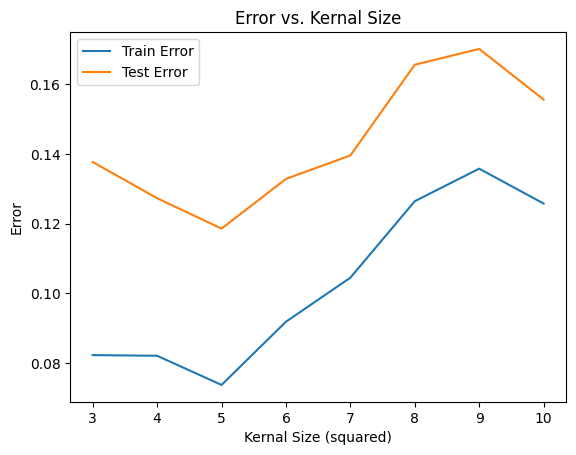

In [13]:
kernal_size = [3,4,5,6,7,8,9,10]
batch_size = 5
num_epochs = 25
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
# First, converting our data into tensors
X_tr_transposed = X_tr.transpose((3, 2, 0, 1))
device = torch.device("cuda")

X_tr_tensor = torch.from_numpy(X_tr_transposed).float().to(device)
y_tr_tensor = torch.from_numpy(y_tr).long().to(device)

# Converting our tensors into a Tensor Dataset
train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, y_tr_tensor)

# Creating a loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

n_total_steps = len(train_loader)
trainErr = []
testErr = []
for k in kernal_size:
    model = ConvNet(feature_map=20, kernel=k).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print(f"trying kernal size: {k}x{k}")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}...")
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            labels = labels.squeeze()
            # Zeroing gradient
            optimizer.zero_grad()

            # Forward pass
            # (batch_size, 3, 32, 32)
            # (32, 32, 3, batch_size)
            outputs = model(inputs)

            # Applying loss
            loss = criterion(outputs, labels)

            # Backpropogation
            loss.backward()

            # Update our weights
            optimizer.step()
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
    testErr.append(1-test(X_te, y_te, model, k, 20))
    trainErr.append(1-test(X_tr, y_tr, model, k, 20))
plt.plot(kernal_size, trainErr, label="Train Error")
plt.plot(kernal_size, testErr, label="Test Error")
plt.xlabel("Kernal Size (squared)")
plt.ylabel("Error")
plt.title("Error vs. Kernal Size")
plt.xticks(kernal_size)
plt.legend()
plt.show()

In [54]:
    num_epochs = 25
    batch_size = 20
    learning_rate = 0.001

    criterion = nn.CrossEntropyLoss()
    # First, converting our data into tensors
    # print(X_tr.shape)
    X_tr_transposed = X_tr.transpose((0, 3, 1, 2))
    print(X_tr_transposed.shape)
    print(y_tr.shape)
    # X_tr_transposed = X_tr
    # print(X_tr_transposed.shape)
    
    X_tr_tensor = torch.from_numpy(X_tr_transposed).float().to(device)
    y_tr_tensor = torch.from_numpy(y_tr).long().to(device)

    # Converting our tensors into a Tensor Dataset
    train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, y_tr_tensor)

    # Creating a loader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    n_total_steps = len(train_loader)
    model = ConvNet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.conv2 = nn.Conv2d(6, 5, 5)
    model.fc1 = nn.Linear(5*5*5, 120)
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            labels = labels.squeeze()
            # Zeroing gradient
            optimizer.zero_grad()

            # Forward pass
            # (batch_size, 3, 32, 32)
            # (32, 32, 3, batch_size)
            outputs = model.forward(inputs, 5)

            # Applying loss
            loss = criterion(outputs, labels)

            # Backpropogation
            loss.backward()

            # Update our weights
            optimizer.step()
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
    print("train")
    train_accuracy = test(X_tr, y_tr, model, batch_size, 5)
    print("test")
    test_accuracy = test(X_te, y_te, model, batch_size, 5)

(73257, 1, 32, 32)
(73257, 1)
Epoch [1/25], Batch [1/3663], Loss: 2.2906
Epoch [1/25], Batch [2/3663], Loss: 2.2901
Epoch [1/25], Batch [3/3663], Loss: 2.2865
Epoch [1/25], Batch [4/3663], Loss: 2.2924
Epoch [1/25], Batch [5/3663], Loss: 2.2917
Epoch [1/25], Batch [6/3663], Loss: 2.2946
Epoch [1/25], Batch [7/3663], Loss: 2.2924
Epoch [1/25], Batch [8/3663], Loss: 2.2730
Epoch [1/25], Batch [9/3663], Loss: 2.2971
Epoch [1/25], Batch [10/3663], Loss: 2.2778
Epoch [1/25], Batch [11/3663], Loss: 2.3073
Epoch [1/25], Batch [12/3663], Loss: 2.2810
Epoch [1/25], Batch [13/3663], Loss: 2.2938
Epoch [1/25], Batch [14/3663], Loss: 2.3001
Epoch [1/25], Batch [15/3663], Loss: 2.3057
Epoch [1/25], Batch [16/3663], Loss: 2.2911
Epoch [1/25], Batch [17/3663], Loss: 2.2800
Epoch [1/25], Batch [18/3663], Loss: 2.2910
Epoch [1/25], Batch [19/3663], Loss: 2.3024
Epoch [1/25], Batch [20/3663], Loss: 2.2784
Epoch [1/25], Batch [21/3663], Loss: 2.2951
Epoch [1/25], Batch [22/3663], Loss: 2.3034
Epoch [1/25

In [22]:
test(X_tr, y_tr, model, batch_size, 20)
test(X_te, y_te, model, batch_size, 20)

testing the model...
Number Of Images Tested = 73257

Model Accuracy = 0.8172324829026578
testing the model...
Number Of Images Tested = 26032

Model Accuracy = 0.8034726490473264


0.8034726490473264

changed epoch from 5 to 10, accuracy went from 64 to 83